# Modeling: Developing Accurate Models for credit default

# Summary of the notebook
- Feature engineering
    - Convert the 'request_datetime' and 'reimbursement_date' columns to datetime objects.
    - Extract relevant features from the datetime columns.
    - Create new features
    

- Training and evaluation
    - Split the dataset into training, validation and testing sets.
    - Train multiple machine learning models on training set and evaluate them on validation set
    - Take the best performing model and tune it on the validation set and check for overfitting
    - Evaluate the performance on the test set

- Checking the stability of our algorithm by mesuring the error on simulation_history dataset 

- Comparing our performance with human-level performance
    - Calculate the number of false positive from the simulation_history dataset
    - Compare with the number of false positive from the model on the simulation_history dataset

# Import Librairies

In [12]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import joblib
import sys
import os
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Scikit-learn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE 

# Metrics 
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, roc_auc_score)


In [13]:
# Get the absolute path to the credit_default_prediction directory
credit_default_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Construct the path to the CSV file
data_name = 'train_topred.csv'
data_path = credit_default_dir + '/data/raw/' + data_name

# Load the CSV file into a pandas dataframe
df = pd.read_csv(data_path)
df.head()

,customer_id,simulation_id,loan_id,request_datetime,reimbursement_date,algo1_eligible_amount,algo2_eligible_amount,mean_countcashout_20_weeks,mean_airtime_balance_20_weeks,mean_volotherout,mean_volcashout_20_weeks,mean_balance_20_weeks,ratio_active_profile,awareness_indice,is_default60
0,customer_214568157,simulation_9bdb122d7,loan_234c90053,2021-02-13 15:07:51.392,2021-03-15,28874.872964,24415.986393,0.110198,10.749030,137.356117,43034.784930,4628.804801,0.794999,111105.515189,1.0
1,customer_8b8004a5f,simulation_a21679f89,loan_f2a468b83,2020-07-30 21:37:44.442,2020-08-30,830.339108,4462.503483,0.056128,131.163084,42.401318,5222.767652,3889.942074,0.674275,252011.901109,0.0
2,customer_0d466cdf2,simulation_e57afa639,loan_c1afb3eda,2020-08-23 15:11:42.087,2020-09-22,51822.237442,75189.327491,0.567690,42.266660,312.466782,23038.404464,13800.932517,0.245463,235158.389478,0.0
3,customer_762c8f4bc,simulation_9eaf91941,loan_e6f7a8fbb,2020-08-31 18:00:04.873,2020-09-30,1865.496542,6400.901403,0.169214,111.608549,338.549751,9897.466939,312.578495,0.691704,255626.351269,1.0
4,customer_d1c1529bc,simulation_5d35eb47d,loan_f5ec62598,2021-02-12 17:17:44.344,2021-03-14,4562.433908,5398.122156,0.170014,9.073107,206.502945,3943.852214,135.202018,0.583585,104721.891496,1.0


# Feature engineering

We have create some features that might be useful for our prediction task (see the file data_processing.py). 

In [15]:
# Import the "process_data" function from "data_processing.py"
src_path = os.path.join(credit_default_dir, 'src')
sys.path.append(src_path)
from data_processing import process_data

In [5]:
# apply processing to df
df = process_data(df)
df.head()

,algo1_eligible_amount,algo2_eligible_amount,mean_countcashout_20_weeks,mean_airtime_balance_20_weeks,mean_volotherout,mean_volcashout_20_weeks,mean_balance_20_weeks,ratio_active_profile,awareness_indice,is_default60,...,reimbursement_dayofweek,date_diff,mean_cashout_to_balance_ratio,mean_cashout_to_airtime_ratio,mean_volotherout_to_balance_ratio,algo_diff,total_eligible_amount,min_algo_eligible_amount,max_algo_eligible_amount,mean_algo_eligible_amount
0,28874.872964,24415.986393,0.110198,10.749030,137.356117,43034.784930,4628.804801,0.794999,111105.515189,1.0,...,0,29,9.297170,4003.597171,0.029674,4458.886571,53290.859357,24415.986393,28874.872964,26645.429678
1,830.339108,4462.503483,0.056128,131.163084,42.401318,5222.767652,3889.942074,0.674275,252011.901109,0.0,...,6,30,1.342634,39.818884,0.010900,3632.164375,5292.842591,830.339108,4462.503483,2646.421296
2,51822.237442,75189.327491,0.567690,42.266660,312.466782,23038.404464,13800.932517,0.245463,235158.389478,0.0,...,1,29,1.669337,545.072748,0.022641,23367.090049,127011.564933,51822.237442,75189.327491,63505.782467
3,1865.496542,6400.901403,0.169214,111.608549,338.549751,9897.466939,312.578495,0.691704,255626.351269,1.0,...,2,29,31.663941,88.680186,1.083087,4535.404861,8266.397946,1865.496542,6400.901403,4133.198973
4,4562.433908,5398.122156,0.170014,9.073107,206.502945,3943.852214,135.202018,0.583585,104721.891496,1.0,...,6,29,29.170069,434.674958,1.527366,835.688248,9960.556064,4562.433908,5398.122156,4980.278032


# Training and evaluation

## Train-val-test split

In [6]:
# Split the dataset into training, validation and testing sets:
X = df.drop('is_default60', axis=1)
y = df['is_default60']

# First, we split the dataset into train (80%) and a temporary test set (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Next, we split the temporary test set into validation (10%) and test sets (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Model selection

Since it is a classification problem, lets experiment with different classification algorithm with increasing complexity : 
- Logistic regression 
- Decision tree
- Random Forest
- XgBoost

First we will compare their performance on the validation set with their default parameters


LogisticRegression - Validation Set Performance
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.84      0.75      7474
         1.0       0.58      0.35      0.44      4669

    accuracy                           0.65     12143
   macro avg       0.63      0.60      0.59     12143
weighted avg       0.64      0.65      0.63     12143

AUC Score: 0.6804966147225711

RandomForestClassifier - Validation Set Performance
Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.81      0.75      7474
         1.0       0.59      0.44      0.50      4669

    accuracy                           0.67     12143
   macro avg       0.65      0.63      0.63     12143
weighted avg       0.66      0.67      0.66     12143

AUC Score: 0.7035913978482299

XGBClassifier - Validation Set Performance
Classification Report:
              precision    recall  f1-score   support

         0.0    

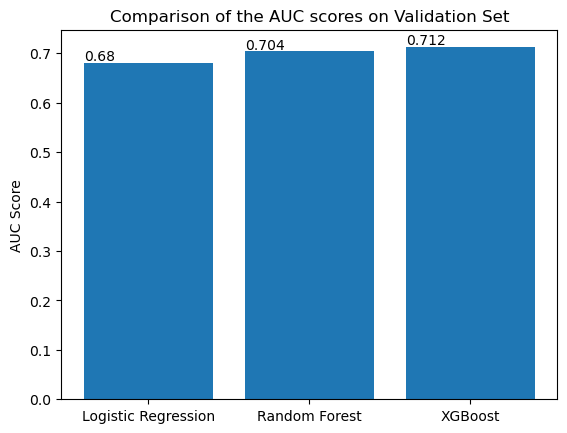

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Scale the features (this is needed only for logistic regression but we need to do it for all the algorithms in order to compare them on the same basis)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Instantiate models
logreg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

# Fit models on training set
logreg.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)
xgb.fit(X_train_scaled, y_train)

# Evaluate model performance on validation set
models = [logreg, rf, xgb]
auc_scores = []
for model in models:
    y_pred_val = model.predict(X_val_scaled)
    y_prob_val = model.predict_proba(X_val_scaled)[:, 1]
    print("\n" + str(model.__class__.__name__) + " - Validation Set Performance")
    print("Classification Report:")
    print(classification_report(y_val, y_pred_val))
    auc = roc_auc_score(y_val, y_prob_val)
    auc_scores.append(auc)
    print("AUC Score:", auc)

# Plot AUC scores with error bars
fig, ax = plt.subplots()
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
auc_scores_rounded = [round(auc, 3) for auc in auc_scores]
bars = ax.bar(models, auc_scores, capsize=10)
ax.set_ylabel('AUC Score')
ax.set_title('Comparison of the AUC scores on Validation Set')
# Add AUC scores to the bars
for bar, auc in zip(bars, auc_scores_rounded):
    yval = bar.get_height()
    ax.text(bar.get_x(), yval + 0.005, auc, fontsize=10)
plt.show()


The best performing model is XGBoost. Lets tune it in order to find the best hyperparameters.
Not that we have removed the scaling step since tree-based models dont need it. 

## XGBoost hyperparameter tuning

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [6, 10, 50],
    'min_child_weight': [3, 6, 10]
}

xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

xgb_tuned = XGBClassifier(**best_params, random_state=42)
xgb_tuned.fit(X_train, y_train)
y_pred_xgb_tuned = xgb_tuned.predict(X_val)
y_prob_xgb_tuned = xgb_tuned.predict_proba(X_val)[:, 1]

# Evaluate model performance
print("XGBoost Tuned with best parameters")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb_tuned))
print("\nAUC Score:")
print(roc_auc_score(y_val, y_prob_xgb_tuned))

Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100}
XGBoost Tuned with best parameters

Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.81      0.76      7474
         1.0       0.60      0.47      0.53      4669

    accuracy                           0.68     12143
   macro avg       0.66      0.64      0.64     12143
weighted avg       0.67      0.68      0.67     12143


AUC Score:
0.7201627883638364


In [61]:
import joblib
# Save the best parameters
joblib.dump(best_params, 'models/xgb_best_params.joblib')

# Save the tuned XGBoost model 
joblib.dump(xgb_tuned, 'models/xgb_tuned.joblib')

['models/xgb_tuned.joblib']

In [24]:
y_pred_xgb_tuned = xgb_tuned.predict(X_val)
y_prob_xgb_tuned = xgb_tuned.predict_proba(X_val)[:, 1]

In [25]:
# Evaluate performance on the test set 
y_pred_xgb_tuned_test = xgb_tuned.predict(X_test)
y_prob_xgb_tuned_test = xgb_tuned.predict_proba(X_test)[:, 1]

# Evaluate model performance
print("XGBoost Tuned with best parameters - test set")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_tuned_test))
print("\nAUC Score:")
print(roc_auc_score(y_test, y_prob_xgb_tuned_test))

XGBoost Tuned with best parameters - test set

Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.81      0.75      7357
         1.0       0.61      0.48      0.54      4787

    accuracy                           0.68     12144
   macro avg       0.66      0.64      0.64     12144
weighted avg       0.67      0.68      0.67     12144


AUC Score:
0.7214909018435736


The model didn't overfit the validation set and generalize with similar performance on the test set

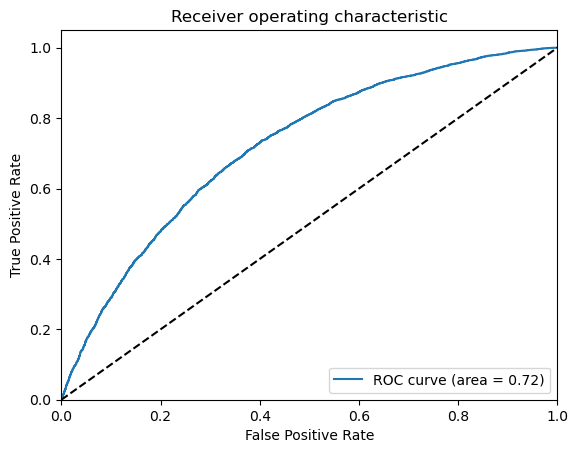

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_val, y_prob_xgb_tuned)
roc_auc = roc_auc_score(y_val, y_prob_xgb_tuned)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")
plt.show()


## Handling class imbalance

To address class imbalance, we'll use SMOTE to oversample the minority class.

In [110]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

# Create a SMOTE object
smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy='minority')

# Apply SMOTE to training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a XGBoost model on SMOTE-applied training data
xgb_tuned_smote_model = XGBClassifier(**best_params, random_state=42)
xgb_tuned_smote_model.fit(X_train_smote, y_train_smote)

# Make predictions on test data
y_pred_xgb_smote = xgb_tuned_smote_model.predict(X_test)
y_prob_xgb_smote = xgb_tuned_smote_model.predict_proba(X_test)[:, 1]

# Evaluate model performance
print("XGBoost Tuned with SMOTE")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_smote))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_smote))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_xgb_smote))
print("\nAUC Score:")
print(roc_auc_score(y_test, y_prob_xgb_smote))

XGBoost Tuned with SMOTE
Confusion Matrix:
[[5363 1994]
 [2009 2778]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73      7357
         1.0       0.58      0.58      0.58      4787

    accuracy                           0.67     12144
   macro avg       0.65      0.65      0.65     12144
weighted avg       0.67      0.67      0.67     12144


Accuracy Score:
0.6703722002635046

AUC Score:
0.7168164543550068


- The confusion matrix shows that the model is able to correctly identify 73% of non-defaulters and 58% of defaulters. 
- The classification report also shows that the model has a better precision and recall for non-defaulters as compared to defaulters. 
- The AUC score of 0.716 indicates that the model is performing better than a random classifier. However, further improvements can be made by using more sophisticated techniques such as neural networks or ensemble models.

In [106]:
# Save the model
joblib.dump(xgb_tuned_smote_model, 'models/xgb_tuned_smote_model.joblib')

['models/xgb_tuned_smote_model.joblib']

### Choosing the SMOTE Model 

From a business perspective, it can be advantageous to minimize the number of customers who are incorrectly predicted to not default when they actually will (i.e., minimize false negatives). Therefore, focusing on maximizing recall is an appropriate strategy.

In this case, the model with SMOTE has the following results compared to the alternative model:
- Precision: 0.07 points lower
- Recall: 0.09 points higher
- AUC is almost the same (0.01 points lower)

Opting for the SMOTE model is a reasonable choice, as it offers a better recall, which aligns with the goal of reducing false negatives. Additionally, the SMOTE model provides a more balanced result in terms of precision and recall, which can contribute to a more effective credit risk assessment.


### Predicting default for 'test_topred' dataframe and saving the results

In [107]:
from data_processing import process_data

# Load the data to be predicted
test_data = pd.read_csv('test_topred.csv')

# Extract loan_id column and store it separately
loan_ids = test_data['loan_id']

# Process the data
test_data_processed = process_data(test_data)

# Make predictions
predictions = xgb_tuned_smote_model.predict(test_data_processed)

# Create a new dataframe with loan_id and prediction columns
predictions_df = pd.DataFrame({'loan_id': loan_ids, 'prediction': predictions})

# Print the dataframe
print(predictions_df)

# Save the dataframe
predictions_df.to_csv('test_with_pred.csv', index=False)

              loan_id  prediction
0      loan_cd4c2e979           0
1      loan_d9bb16aab           0
2      loan_9c8277e30           1
3      loan_adffbc956           0
4      loan_4cfc001f8           0
...               ...         ...
49995  loan_ab8a84888           1
49996  loan_ba873142e           1
49997  loan_1d79c0d91           0
49998  loan_dcf316fb1           0
49999  loan_4d27d9a86           1

[50000 rows x 2 columns]


## Feature selection

We'll use the feature importances from the XGBoost model to select the top features.

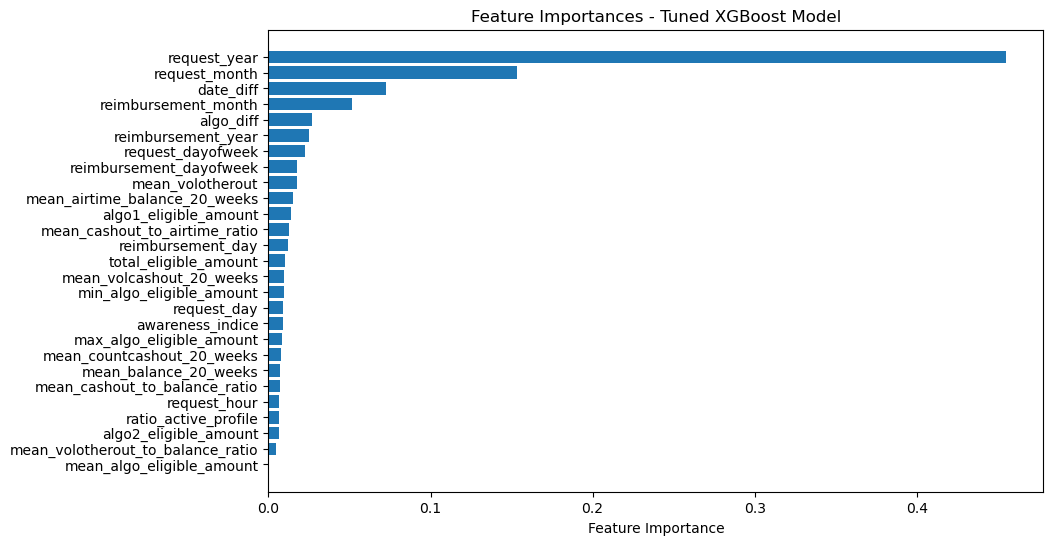

In [32]:
# Get feature importances
feature_importances = xgb_tuned.feature_importances_

# Get feature names
feature_names = X_train.columns

# Create a sorted index of feature importances
sorted_idx = np.argsort(feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importances - Tuned XGBoost Model')
plt.show()


### To go further

### Possible Improvements


Here are some ideas to further improve the project:

- Retrain the XGBoost model using only the top 10 most important features identified from feature importance analysis. This may help to simplify the model and reduce overfitting. 
- Explore the use of SMOTE (Synthetic Minority Over-sampling Technique) as a hyperparameter in the XGBoost tuning. This technique may help to balance the class distribution and improve the model's ability to predict defaults.
- Gather additional information about the loan amount and use it as a feature in the model. This could potentially improve the model's performance by capturing the relationship between loan amount and default risk.